In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import deque

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.model_selection import TimeSeriesSplit


In [3]:
data_file_path = '../data/processed/'

train_data_file_name = 'wastewater_tank1_processed_train.csv'
val_data_file_name = 'wastewater_tank1_processed_val.csv'


In [5]:
N_ROWS_IN_DAY = int(24*60)
LEN_PRED_HORIZON = 60

In [7]:
train_df = pd.read_csv(data_file_path + train_data_file_name, parse_dates = ["time"])
val_df = pd.read_csv(data_file_path + val_data_file_name, parse_dates = ["time"])

# Modelling Setup

The goal is to take 22 hours of measurement of the tank variables, and predict the next 40 minutes of N2O.



## Naive Baseline Model

The predicted values of N2O are all equal to the last observed value.

In [11]:
def naive_persistence(series, horizon = LEN_PRED_HORIZON):
    """
    Evaluate a naive persistence baseline on a univariate time series for N2O.

    The persistence baseline predicts that the next `horizon` values
    are equal to the last observed value in the input window.

    Parameters
    ----------
    series : array-like
        1D array or Pandas Series containing the time series values for N2O.
    horizon : int
        Number of future timesteps to predict.

    Returns
    -------
    array
        1D array predicting the next horizon h values.
    """
    
    last_val_ind = len(series) - 1
    
    return np.array(horizon*[series[last_val_ind]])

def RMSE_persistence(val_df):
    # Split into data points
    N2O_vals = val_df['N2O'].to_numpy()

    n_data_points = len(N2O_vals) - N_ROWS_IN_DAY + 1

    datapoints = np.lib.stride_tricks.sliding_window_view(N2O_vals, N_ROWS_IN_DAY)

    rows_with_nan = np.isnan(datapoints).any(axis=1)
    rows_without_nan = ~rows_with_nan
    datapoints = datapoints[rows_without_nan]

    errors = []

    for i, datapoint in enumerate(datapoints):
        errors.append(RMSE(naive_persistence(datapoint[:-LEN_PRED_HORIZON], horizon = LEN_PRED_HORIZON), datapoint[-LEN_PRED_HORIZON:]))

    return np.mean(errors)


In [13]:
print("persistence model RMSE on validation set: ", RMSE_persistence(val_df))

persistence model RMSE on validation set:  0.058366322282711866


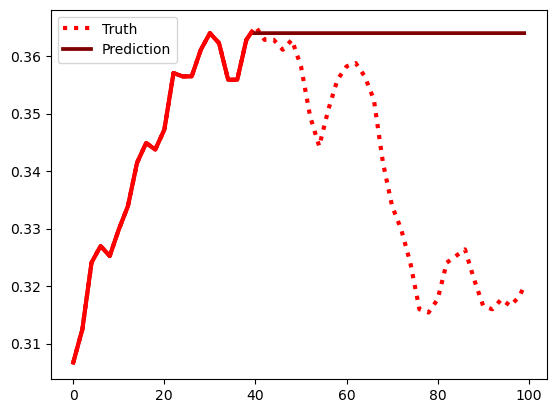

In [67]:
plot_test_TRUTH = val_df[4000:4000 + N_ROWS_IN_DAY]['N2O'].to_numpy()
plot_test_baseline_pred = np.concatenate((plot_test_TRUTH[:-LEN_PRED_HORIZON], naive_persistence(plot_test_TRUTH[:-LEN_PRED_HORIZON])))


plt.plot(plot_test_TRUTH[-100:], linestyle=':', color = 'r', linewidth = 3, label = 'Truth')
plt.plot(plot_test_baseline_pred[-100:], color = 'maroon', linewidth = 2.7, label = 'Prediction')
plt.plot(plot_test_TRUTH[-100:-LEN_PRED_HORIZON], color = 'r',linewidth = 3)
plt.legend()

In [45]:
def naive_rolling_mean(series, window, horizon = LEN_PRED_HORIZON):
    """
    Evaluate a naive rolling mean baseline on a univariate time series for N2O.

    The rolling mean baseline predicts that the next value in a timestep is
    equal to the mean of the last observed values in the input window.

    This operation is recursively performed for the next `horizon` values.

    Parameters
    ----------
    series : array-like
        1D array or Pandas Series containing the time series values for N2O.
    window : int
        Number of previous timesteps to consider in the rolling mean.
    horizon : int
        Number of future timesteps to predict.

    Returns
    -------
    array
        1D array predicting the next `horizon` values.
    """

    dq = deque(series[-horizon:])

    cumsum = sum(list(dq)[-window:])

    for i in range(horizon):
        mean_last_n = cumsum/window
        dq.append(mean_last_n)
        removed = dq.popleft()
        cumsum -= removed
        cumsum += mean_last_n
    
    return np.array(list(dq)[-horizon:])



def tuning_rolling_mean(datapoints, w):

    errors = []

    for i, datapoint in enumerate(datapoints):
        errors.append(RMSE(naive_rolling_mean(datapoint[:-LEN_PRED_HORIZON], window=w, horizon=LEN_PRED_HORIZON), datapoint[-LEN_PRED_HORIZON:]))

    return np.mean(errors)
    

In [25]:
# Select 50 random datapoints
print("initiating batching")

N_DATA_TO_TEST = 50
N2O_vals = train_df['N2O'].to_numpy()
total_len = len(N2O_vals)
window_size = N_ROWS_IN_DAY

valid_indices = []
for start in range(total_len - window_size + 1):
    window = N2O_vals[start:start + window_size]
    if not np.isnan(window).any():
        valid_indices.append(start)

sampled_starts = np.random.choice(valid_indices, size = N_DATA_TO_TEST, replace=False)

datapoints = np.array([N2O_vals[start:start + window_size] for start in sampled_starts])

print("batching complete")


initiating batching
batching complete


In [63]:
window_lengths = [i for i in range(30, 60)]

average_train_RMSEs = []
for w in window_lengths:

    err = tuning_rolling_mean(datapoints=datapoints, w=w)
    average_train_RMSEs.append(err)
    
best_ind = np.argmin(average_train_RMSEs)
print(f"lowest error on training with window_length w={window_lengths[best_ind]} with error={np.min(average_train_RMSEs)}")

lowest error on training with window_length w=58 with error=0.06770070299588807


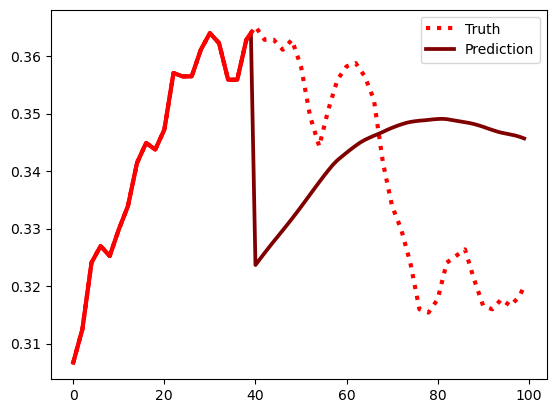

In [65]:
plot_test_TRUTH = val_df[4000:4000 + N_ROWS_IN_DAY]['N2O'].to_numpy()
plot_test_baseline_pred = np.concatenate((plot_test_TRUTH[:-LEN_PRED_HORIZON], naive_rolling_mean(plot_test_TRUTH[:-LEN_PRED_HORIZON], window=58)))


plt.plot(plot_test_TRUTH[-100:], linestyle=':', color = 'r', linewidth = 3, label = 'Truth')
plt.plot(plot_test_baseline_pred[-100:], color = 'maroon', linewidth = 2.7, label = 'Prediction')
plt.plot(plot_test_TRUTH[-100:-LEN_PRED_HORIZON], color = 'r',linewidth = 3)
plt.legend()

In [75]:
def RMSE_rolling_mean(val_df):
    N2O_vals = val_df['N2O'].to_numpy()

    n_data_points = len(N2O_vals) - N_ROWS_IN_DAY + 1

    datapoints = np.lib.stride_tricks.sliding_window_view(N2O_vals, N_ROWS_IN_DAY)

    rows_with_nan = np.isnan(datapoints).any(axis=1)
    rows_without_nan = ~rows_with_nan
    datapoints = datapoints[rows_without_nan]

    errors = []

    for i, datapoint in enumerate(datapoints):
        errors.append(RMSE(naive_rolling_mean(datapoint[:-LEN_PRED_HORIZON], window = 58, horizon = LEN_PRED_HORIZON), datapoint[-LEN_PRED_HORIZON:]))
    
    return np.mean(errors)

In [77]:
print("rolling mean model RMSE on validation set: ", RMSE_rolling_mean(val_df))

rolling mean model RMSE on validation set:  0.0637265487727327
